# GoDaddy - Microbusiness Density Forecasting 

This notebook is created in spirit of this competition: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion?sort=recent-comments

The objective is to have minimum SMAPE score, forecasting three, four and five months in advance; for this reason, I:
- focus on predicting MBD growth instead of raw MBD
- minimize MAE of predicted *growth*
- adjust our CV strategy accordingly

This project was done for leisure purposes, hence involves basic feature engineering for time series, and implements mostly computationally inexpensive algorithms for prediction

I hope this is helpful for any future projects you may have :)

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
import warnings
import geopandas as gpd
import datetime as dt
from math import radians, cos, sin, asin, sqrt
import random

from scipy.stats import linregress, median_abs_deviation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVR
# Walking window CV:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
# bayes opt
from bayes_opt import BayesianOptimization
# light gbm
from lightgbm import LGBMRegressor
# kernel + SGD
from sklearn.kernel_approximation import RBFSampler, SkewedChi2Sampler, PolynomialCountSketch, Nystroem
from sklearn.linear_model import SGDRegressor


# grouped time series split
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)


# handling zip files
import os
import urllib # for downloads
import zipfile # for unzipping

# performance
from numba import jit
from pandarallel import pandarallel
pandarallel.initialize()


# dashboard
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import plotly.graph_objs as go



####################
# custom functions #
####################
from CustomFunctions import preprocessing_functions as pfunc
from CustomFunctions import forecasting_functions as ffunc

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# settings for forecasting
lag_list = [1,2,3]
lag_rolling_list = [1]
max_neighbors = 2
n_rolling_mean = 3
fourier_set = False
states_dummy = False
winsorize = True
winsorize_thresh = 100
k_gwt = 10**(-3)
# for sklearn functions
n_jobs_skl = 7


# below should not be modified!
max_neighbors = max(min(max_neighbors, 5), 0)
neighb_list = list(range(1,max_neighbors+1))
lag_neigh_c = list(itertools.product(lag_list, neighb_list))

## Reading data

In [3]:
train_df = pd.read_csv('data/train.csv')
train_df['year'] = [x.year for x in pd.to_datetime(train_df.first_day_of_month, format="%Y/%m/%d").astype('datetime64[Y]')]
train_df['year'] = train_df['year'].astype(int)
train_df.first_day_of_month = pd.to_datetime(train_df.first_day_of_month, format="%Y/%m/%d")
revealed_test_df = pd.read_csv('data/revealed_test.csv')
test_df = pd.read_csv('data/test.csv')
test_df['year'] = [x.year for x in pd.to_datetime(test_df.first_day_of_month, format="%Y/%m/%d").astype('datetime64[Y]')]
test_df['year'] = test_df['year'].astype(int)
test_df.first_day_of_month = pd.to_datetime(test_df.first_day_of_month, format="%Y/%m/%d")
census_starter = pd.read_csv('data/census_starter.csv', index_col=None)
pop_data = pd.read_csv('data/PopulationEstimates.csv', index_col=None, encoding='latin-1')

In [4]:
revealed_test_df['year'] = 2022

In [5]:
train_df = pd.concat([train_df, revealed_test_df])
test_df = test_df[~test_df['first_day_of_month'].isin(revealed_test_df['first_day_of_month'].unique())]

In [6]:
train_df = train_df.sort_values(['first_day_of_month', 'cfips'])
test_df = test_df.sort_values(['first_day_of_month', 'cfips'])

/tmp/ipykernel_10446/3809519405.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  train_df = train_df.sort_values(['first_day_of_month', 'cfips'])


In [7]:
test_df.shape

(18810, 4)

In [8]:
train_df.shape

(128535, 8)

In [9]:
train_df.sample(5, random_state=1)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year
28857,18089_2022-08-01,18089,Lake County,Indiana,2022-08-01 00:00:00,4.043347,15029,2022
3953,37179_2022-12-01,37179,Union County,North Carolina,2022-12-01,8.952792,15439,2022
85291,40117_2022-09-01,40117,Pawnee County,Oklahoma,2022-09-01 00:00:00,2.745192,344,2022
3561,34019_2022-12-01,34019,Hunterdon County,New Jersey,2022-12-01,11.672018,11778,2022
28411,18067_2021-03-01,18067,Howard County,Indiana,2021-03-01 00:00:00,2.986762,1902,2021


In [10]:
test_df.sample(5, random_state=1)

,row_id,cfips,first_day_of_month,year
11769,46013_2023-02-01,46013,2023-02-01,2023
8581,44007_2023-01-01,44007,2023-01-01,2023
22457,13259_2023-06-01,13259,2023-06-01,2023
18293,48199_2023-04-01,48199,2023-04-01,2023
24521,48115_2023-06-01,48115,2023-06-01,2023


In [11]:
test_df.isna().sum()

row_id                0
cfips                 0
first_day_of_month    0
year                  0
dtype: int64

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128535 entries, 0 to 6269
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 128535 non-null  object 
 1   cfips                  128535 non-null  int64  
 2   county                 128535 non-null  object 
 3   state                  128535 non-null  object 
 4   first_day_of_month     128535 non-null  object 
 5   microbusiness_density  128535 non-null  float64
 6   active                 128535 non-null  int64  
 7   year                   128535 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 8.8+ MB


In [13]:
census_starter.shape

(3142, 26)

In [14]:
census_starter.sample(5, random_state=1)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
1760,78.6,78.7,74.2,85.9,85.8,32029,16.4,20.4,21.8,23.2,...,4.7,5.2,7.2,7.2,7.1,63607,62284.0,66292,64000.0,66713.0
1735,68.8,74.5,75.4,77.2,77.7,31163,12.7,12.5,14.7,14.8,...,0.4,0.8,0.9,1.8,1.8,48704,51172.0,50781,53158.0,57579.0
1186,76.4,79.1,81.6,83.4,84.8,23019,16.7,17.2,17.5,17.7,...,1.7,1.6,1.8,1.5,1.4,47886,49374.0,50808,52128.0,55125.0
2803,83.3,84.9,86.5,87.8,88.9,49053,17.6,17.0,17.3,18.7,...,2.5,2.1,1.7,1.6,1.1,55175,56877.0,59839,61747.0,65040.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0


In [15]:
census_starter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

### Census data

For this dataset, we fill missing values and forecast for the year 2023 with linear interpolation

Since this is panel data, we forecast per group

In [16]:
census_starter = pd.read_csv('data/census_starter.csv', index_col=None)
census_df = census_starter.melt(id_vars=['cfips'])
census_df['year'] = [int(x[-4:]) for x in census_df['variable']]
census_df['year'] = census_df['year'].astype(int)
census_df['variable'] = [x[:(len(x)-5)] for x in census_df['variable']]
census_df = census_df.pivot(index=['year','cfips'], columns=['variable'], values='value').reset_index()
census_df.year = census_df.year.astype(int)
census_df = census_df.ffill(axis = 0)

In [17]:
census_df.sample(5, random_state=1)

variable,year,cfips,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers
6097,2018,53005,65650.0,82.8,18.4,10.6,1.6
7467,2019,23013,57751.0,84.8,21.2,2.3,1.9
506,2017,13243,30640.0,60.7,6.9,2.0,0.3
1565,2017,29165,74199.0,87.5,25.6,5.6,3.0
470,2017,13169,55110.0,77.7,12.3,0.9,0.8


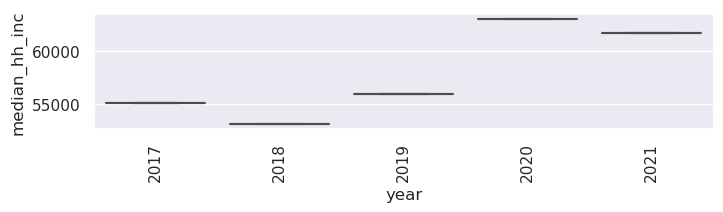

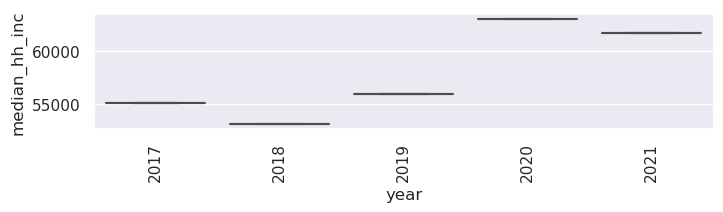

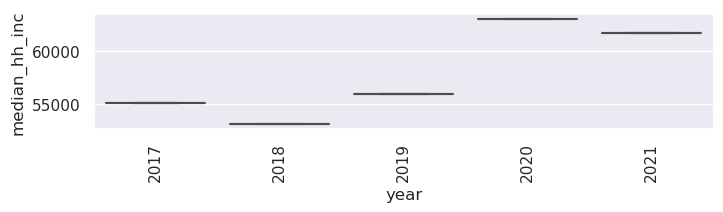

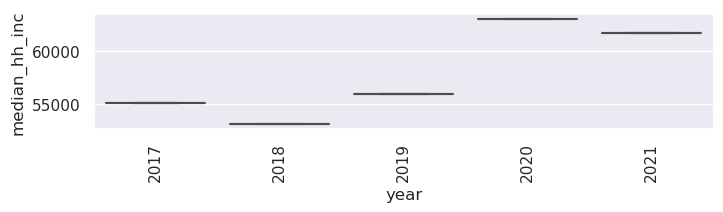

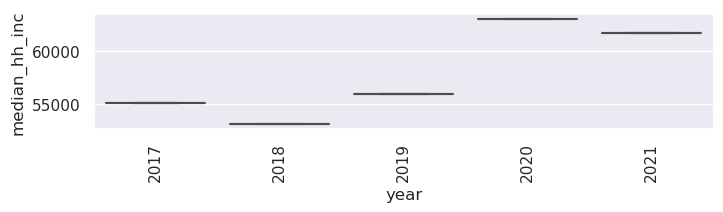

In [18]:
for column in census_df.drop('cfips', axis=1).columns[1:]:
    sns.set()
    fig, ax = plt.subplots()
    sns.boxplot(data = census_df[census_df.cfips==13169], x='year',y=('median_hh_inc'))
    fig.set_size_inches(8,1.5)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

**Note:** this function could use some optimization (I have not dedicated attention to this part's performance)

In [19]:
def forecast_per_group(col, year, cfips):
    _X=census_df[census_df.cfips == cfips]['year']
    _y=census_df[census_df.cfips == cfips][col]
    slope, intercept, _, _, _ = linregress(_X, _y)
    return intercept + year*slope

def forecast_array(df, col, year):
    return [forecast_per_group(col, year, cfips) for cfips in df.cfips]

def forecast_fill_df(df, year):
    df_return = df.copy()
    _column_list = census_df.columns[2:]
    for column in _column_list:
        df_return[column] = forecast_array(df, column, year)
    return df_return

In [20]:
census_2022 = pd.DataFrame(np.repeat(2022,len(census_df.cfips.unique())), columns=['year'])
census_2022['cfips'] = census_df.cfips.unique()

In [21]:
census_2022 = forecast_fill_df(census_2022, 2022)

In [22]:
census_2023 = pd.DataFrame(np.repeat(2023,len(census_df.cfips.unique())), columns=['year'])
census_2023['cfips'] = census_df.cfips.unique()
census_2023 = forecast_fill_df(census_2023, 2023)

In [23]:
census_df = census_df.append(census_2022, ignore_index = True).append(census_2023, ignore_index = True)

/tmp/ipykernel_10446/3864560008.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  census_df = census_df.append(census_2022, ignore_index = True).append(census_2023, ignore_index = True)


#### Merging to the train and test datasets

In [24]:
train_df = pd.merge(train_df, census_df, how='left', left_on=['cfips','year'], right_on=['cfips','year'])

In [25]:
test_df = pd.merge(test_df, census_df, how='left', left_on=['cfips','year'], right_on=['cfips','year'])
test_df = pd.merge(test_df, train_df[['cfips','county','state']], how='left', left_on=['cfips'], right_on=['cfips']).drop_duplicates()

### Entrepreneur survey

Extra data regarding traffic, orders, etcetera for microbusinesses

Source: https://www.godaddy.com/ventureforward/microbusiness-datahub/

In [26]:
vf_data = pd.read_csv('data/commercial_activity/VF_indcom_counties_Q222.csv')
vf_data = vf_data.dropna(axis=0)
vf_data.cfips = vf_data.cfips.astype(int)

In [27]:
vf_data.head()

,cfips,county,state,groupflag,total_pop_20,orders_rank_aug19,orders_rank_sep19,orders_rank_oct19,orders_rank_nov19,orders_rank_dec19,...,avg_traffic_oct21,avg_traffic_nov21,avg_traffic_dec21,avg_traffic_jan22,avg_traffic_feb22,avg_traffic_mar22,avg_traffic_apr22,avg_traffic_may22,avg_traffic_jun22,avg_lifespan_mths
0,1001,Autauga,AL,30k - 225k pop,55639.0,668.0,511.0,723.0,624.0,1023.0,...,419.1,455.9,480.9,663.0,629.7,647.6,435.2,415.0,398.9,12.4
1,1003,Baldwin,AL,30k - 225k pop,218289.0,804.0,780.0,831.0,899.0,705.0,...,124.2,113.1,108.1,126.7,125.9,135.4,134.5,145.8,152.9,13.9
3,1007,Bibb,AL,< 30k pop,22374.0,123.0,96.0,113.0,199.0,195.0,...,132.2,124.7,113.1,101.9,69.3,74.4,65.1,69.6,91.1,14.8
4,1009,Blount,AL,30k - 225k pop,57755.0,65.0,108.0,203.0,121.0,313.0,...,62.8,70.8,70.9,95.8,67.5,64.8,84.7,108.3,88.4,14.8
7,1015,Calhoun,AL,30k - 225k pop,114324.0,458.0,526.0,734.0,755.0,894.0,...,112.1,107.4,125.7,145.7,203.1,131.8,142.4,152.8,111.9,12.3


In [28]:
vf_data_ts = vf_data.melt(id_vars=['cfips','county','state','groupflag'])
vf_data_ts = vf_data_ts[~vf_data_ts.variable.isin(['total_pop_20', 'avg_lifespan_mths'])]

In [29]:
vf_data_ts['year'] = [2000+int(x[-2:]) for x in vf_data_ts['variable']]
vf_data_ts['year'] = vf_data_ts['year'].astype(int)
vf_data_ts['variable'] = [x[:(len(x)-2)] for x in vf_data_ts['variable']]
vf_data_ts['month'] = [x[-3:] for x in vf_data_ts['variable']]
vf_data_ts['variable'] = [x[:(len(x)-4)] for x in vf_data_ts['variable']]

In [30]:
def date_converter(x):
    return dt.datetime.strptime(x['month']+' '+str(x['year']), '%b %Y').date()

In [31]:
vf_data_ts['first_day_of_month'] = vf_data_ts.apply(date_converter, axis=1)

In [32]:
vf_data_ts.head(3)

,cfips,county,state,groupflag,variable,value,year,month,first_day_of_month
1857,1001,Autauga,AL,30k - 225k pop,orders_rank,668.0,2019,aug,2019-08-01
1858,1003,Baldwin,AL,30k - 225k pop,orders_rank,804.0,2019,aug,2019-08-01
1859,1007,Bibb,AL,< 30k pop,orders_rank,123.0,2019,aug,2019-08-01


In [33]:
vf_data_ts = vf_data_ts.drop(['year','month'], axis=1)

In [34]:
#vf_data = 
vf_data_ts = vf_data_ts.pivot_table(index=['cfips','county','state','groupflag','first_day_of_month'], columns=['variable'], values='value', aggfunc='sum').reset_index()
vf_data_ts.head()

variable,cfips,county,state,groupflag,first_day_of_month,avg_traffic,gmv_rank,merchants_rank,orders_rank,top3industries
0,1001,Autauga,AL,30k - 225k pop,2019-08-01,51.7,693.0,342.0,668.0,"fashion, beauty, homesvcs"
1,1001,Autauga,AL,30k - 225k pop,2019-09-01,49.4,396.0,550.0,511.0,"beauty, homesvcs"
2,1001,Autauga,AL,30k - 225k pop,2019-10-01,54.8,825.0,699.0,723.0,"beauty, fashion"
3,1001,Autauga,AL,30k - 225k pop,2019-11-01,47.1,571.0,491.0,624.0,"beauty, fashion, homesvcs"
4,1001,Autauga,AL,30k - 225k pop,2019-12-01,52.7,1026.0,777.0,1023.0,"beauty, homesvcs"


In [35]:
vf_data_ts.first_day_of_month.max()

datetime.date(2022, 6, 1)

In [36]:
vf_data_ts = vf_data_ts.drop(['county','state','groupflag','top3industries'], axis=1) 

In [37]:
vf_data_ts.isna().sum()

variable
cfips                 0
first_day_of_month    0
avg_traffic           0
gmv_rank              0
merchants_rank        0
orders_rank           0
dtype: int64

#### Merging
Note: since we only have data until June 2022, we merge only for the train data, and apply 12-month lagged values later

In [38]:
train_df.first_day_of_month = pd.DatetimeIndex(train_df.first_day_of_month)

In [39]:
def dt_to_date(x): return x['first_day_of_month'].date()
train_df.first_day_of_month = train_df.apply(dt_to_date, axis=1)

In [40]:
test_df.first_day_of_month = test_df.apply(dt_to_date, axis=1)

In [41]:
train_df = pd.merge(train_df, vf_data_ts, how='left', left_on=['cfips','first_day_of_month'], right_on=['cfips','first_day_of_month'])

----------------------
We handle missing values by imputing the median, by date:

In [42]:
train_df.drop('first_day_of_month', axis=1).isna().groupby(train_df.first_day_of_month).sum().reset_index().tail(10)

,first_day_of_month,row_id,cfips,county,state,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,avg_traffic,gmv_rank,merchants_rank,orders_rank
31,2022-03-01,0,0,0,0,0,0,0,0,0,0,0,0,1279,1279,1279,1279
32,2022-04-01,0,0,0,0,0,0,0,0,0,0,0,0,1279,1279,1279,1279
33,2022-05-01,0,0,0,0,0,0,0,0,0,0,0,0,1279,1279,1279,1279
34,2022-06-01,0,0,0,0,0,0,0,0,0,0,0,0,1279,1279,1279,1279
35,2022-07-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
36,2022-08-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
37,2022-09-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
38,2022-10-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
39,2022-11-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
40,2022-12-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135


In [43]:
vf_data_ts.columns[2:]

Index(['avg_traffic', 'gmv_rank', 'merchants_rank', 'orders_rank'], dtype='object', name='variable')

In [44]:
list_cols_with_na = train_df.isna().sum(0)[train_df.isna().sum(0)>0].index

In [45]:
col_group = ['first_day_of_month','state']
list_cols_with_na = train_df.isna().sum(0)[train_df.isna().sum(0)>0].index
warnings.simplefilter("ignore")
try:
    for colname in list_cols_with_na:
        train_df[colname] = train_df.groupby(col_group, sort=False)[colname].transform(lambda x: x.median())
finally:
    warnings.simplefilter("default")

In [46]:
train_df.drop('first_day_of_month', axis=1).isna().groupby(train_df.first_day_of_month).sum().reset_index().tail(10)

,first_day_of_month,row_id,cfips,county,state,microbusiness_density,active,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,avg_traffic,gmv_rank,merchants_rank,orders_rank
31,2022-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,2022-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,2022-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,2022-06-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,2022-07-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
36,2022-08-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
37,2022-09-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
38,2022-10-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
39,2022-11-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135
40,2022-12-01,0,0,0,0,0,0,0,0,0,0,0,0,3135,3135,3135,3135


## Preprocessing data / feature engineering

### Nearest 5 spatial neighbors

We attempt to account for spatial correlation by including 5 nearest counties' MBD for each county

Source of coordinates data: https://public.opendatasoft.com/explore/dataset/us-county-boundaries/export/?disjunctive.statefp&disjunctive.countyfp&disjunctive.name&disjunctive.namelsad&disjunctive.stusab&disjunctive.state_name

In [47]:
# download zip and unzip it, only if it does not exist

if not os.path.isfile("data/us-county-boundaries.zip"):
    urllib.request.urlretrieve(
        "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/us-county-boundaries/exports/shp?lang=en&timezone=Europe%2FBerlin",
        "data/us-county-boundaries.zip")
    with zipfile.ZipFile("data/us-county-boundaries.zip", 'r') as zip_ref:
        zip_ref.extractall('data')

In [48]:
us_shape = gpd.read_file("data/us-county-boundaries.shp")

us_shape['fips'] = us_shape['statefp'] + us_shape['countyfp']
us_shape['fips'] = us_shape['fips'].astype(int)
us_shape['intptlat'] = us_shape['intptlat'].astype(float)
us_shape['intptlon'] = us_shape['intptlon'].astype(float)

# merging with spatial data
train_df = pd.merge(train_df, us_shape[['countyfp','fips','intptlat','intptlon','geometry']],
                    left_on='cfips', right_on='fips', how='left')
test_df = pd.merge(test_df, us_shape[['countyfp','fips','intptlat','intptlon','geometry']],
                   left_on='cfips', right_on='fips', how='left')

train_df = train_df.rename(columns={'intptlon':'lon', 'intptlat':'lat'})
test_df = test_df.rename(columns={'intptlon':'lon', 'intptlat':'lat'})

In [49]:
# for obtaining nearest neighbors, we only need to use one moment of time - we choose
# the first date available, but it can be any
train_first_date = train_df[train_df.first_day_of_month==min(train_df.first_day_of_month)]

In [50]:
# function for finding nearest N county, by coordinates
def find_nearest(row, n):
    k=10
    distances = train_first_date.apply(
        dist_row, lat=row['lat'], long=row['lon'], 
        axis=1)
    return train_first_date.loc[distances.nsmallest(k+1).index[k-n], 'cfips']


@jit(nopython=True) # wrapper for C compiler (does not support pandas, only numpy
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# function for vectorizing across a pandas dataframe
def dist_row(row, lat, long):
    return dist(lat, long, row['lat'], row['lon'])

In [51]:
train_first_date = train_df[train_df.first_day_of_month==min(train_df.first_day_of_month)]

In [52]:
if os.path.isfile("data/5_nearest.csv"):
    agg = pd.read_csv('data/5_nearest.csv')
else:

    import time

    start=time.time()

    cols, names = list(), list()
    max_max_neighbors=5
    for i in range(1,max_max_neighbors+1):
        nearest_cfips = pd.DataFrame(train_first_date.parallel_apply(find_nearest, n=i, axis=1))
        cols.append(nearest_cfips)
        names += [f'mbd_nearest_{i}']

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    pandarallel.initialize()
    
    agg['cfips'] = train_first_date.cfips
    end=time.time()
    print(' '.join(['Time to compute: ',str(start-end),'seconds']))

In [53]:
agg.head()

,mbd_nearest_1,mbd_nearest_2,mbd_nearest_3,mbd_nearest_4,mbd_nearest_5,cfips
0,1117,1007,1105,1037,1101,1001
1,1099,28041,1129,28039,28059,1003
2,13243,13259,1045,1109,1113,1005
3,1063,1047,1001,1073,1065,1007
4,1133,1015,1127,1103,1073,1009


In [54]:
train_df = pd.merge(train_df, agg, on='cfips')

In [55]:
try:
    pd.options.mode.chained_assignment = None
    for date in train_df.first_day_of_month.unique():
        print('Date of iteration: '+ str(date), end = "\r")
        for i in range(1,6):
            _mbd_array = train_df[train_df.first_day_of_month==date].sort_values(by=[f'mbd_nearest_{i}'], key=lambda x: x.map(agg[f'mbd_nearest_{i}'].to_dict()))
            _mbd_array = _mbd_array['microbusiness_density']
            _mbd_array = _mbd_array.reindex(train_df[train_df.first_day_of_month==date].index)
            train_df[f'mbd_nearest_{i}'][_mbd_array.index] = _mbd_array
finally:
    pd.options.mode.chained_assignment = 'warn'

In [56]:
train_df.isna().sum()

row_id                       0
cfips                        0
county                       0
state                        0
first_day_of_month           0
microbusiness_density        0
active                       0
year                         0
median_hh_inc                0
pct_bb                       0
pct_college                  0
pct_foreign_born             0
pct_it_workers               0
avg_traffic              18810
gmv_rank                 18810
merchants_rank           18810
orders_rank              18810
countyfp                     0
fips                         0
lat                          0
lon                          0
geometry                  2050
mbd_nearest_1                0
mbd_nearest_2                0
mbd_nearest_3                0
mbd_nearest_4                0
mbd_nearest_5                0
dtype: int64

**Note:** Missing values for MBD survey data are explained due to lack of availability from Q3 2022 onwards; we solve that via lagging these survey values

In [57]:
train_df = train_df.drop('geometry', axis=1)
test_df = test_df.drop('geometry', axis=1)

### Lagged values and feature engineering

For selecting lag order of variables and of rolling mean, we check for autocorrelation, partial autocorrelation, and cross-correlation

Since Python does not have the same support as R for longitudinal data (grouped time series), we limit ourselves to using random samples of ACF, PACF and CCF

In [58]:
train_df = train_df_backup.copy()
test_df = test_df_backup.copy()

NameError: name 'train_df_backup' is not defined

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(data = train_df, x='state',y=('microbusiness_density'))

fig.set_size_inches(15,5)
for item in ax.get_xticklabels():
    item.set_rotation(90)

------------------
We check how many lags to use by checking ACF and partial ACF plots:

In [ ]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 3)

for cfips in sample_cfips:
    sns.set()
    fig, ax = plt.subplots()
    plot_acf(train_df[train_df.cfips==cfips]['microbusiness_density'], ax=ax, lags=18)
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

In [ ]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 3)

for cfips in sample_cfips:
    sns.set()
    fig, ax = plt.subplots()
    plot_pacf(train_df[train_df.cfips==cfips]['microbusiness_density'], ax=ax, lags=15)
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

In [ ]:
from scipy import signal
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 5)

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(lags, ccf, title):
    fig, ax =plt.subplots(figsize=(12, 2))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title(title, weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()


#ccf_vals = ccf_values(train_df[train_df.cfips==1001]['log_mbd'], train_df[train_df.cfips==1001]['active'])
#lags = signal.correlation_lags(len(train_df[train_df.cfips==1001]['log_mbd']), len(train_df[train_df.cfips==1001]['active']))

#ccf_plot(lags, ccf_vals)

In [ ]:
import random
sample_cfips = random.sample(train_df.cfips.unique().tolist(), 3)

for cfips in sample_cfips:
    ccf_vals = ccf_values(train_df[train_df.cfips==cfips]['microbusiness_density'], train_df[train_df.cfips==cfips]['mbd_nearest_1'])
    lags = signal.correlation_lags(len(train_df[train_df.cfips==cfips]['microbusiness_density']), len(train_df[train_df.cfips==cfips]['mbd_nearest_1']))
    sns.set()
    #fig, ax = plt.subplots()
    ccf_plot(lags, ccf_vals, title='Cross Correation microbusiness_density and nearest neighbor')
    fig.set_size_inches(8,2)
    for item in ax.get_xticklabels():
        item.set_rotation(90) 

-------------------------------------------
Considering that the autocorrelation is significant until lag 3, and that the parcial AC is significant until lag 1, the idea for feature engineering is:
- Rolling window of previous three months for key variables
- Up to 3-month lagged variables for the rest, except for...
- ...entrepreneur survey data, where we can only use it up to lag 12 considering the availability of data

-------------------------------------------

#### Adding lagged values

For months with infinite growth (divided by zero), a small bias is introduced:

$\large{\texttt{gwt_m}_{t}=\frac{\texttt{gwt_m}_{t}+c}{\texttt{gwt_m}_{t-1}+c}\small \text{, where }c=10^{-6}}$

In [ ]:
train_df = train_df_backup.copy()
test_df = test_df_backup.copy()

In [ ]:
train_df['gwt_m'] = pfunc.gwt_f(train_df, 'microbusiness_density', time_gwt=1, lag=0)
train_df['gwt_q'] = pfunc.gwt_f(train_df, 'microbusiness_density', time_gwt=3, lag=0)
if np.max(lag_list)>=9:
    train_df['active(t-12)']=pfunc.shift_time(train_df, 12)['active']
for i in range(1,max_neighbors+1):
    train_df[f'gwt_m_nearest_{i}']=pfunc.gwt_f(train_df, f'mbd_nearest_{i}', time_gwt=1, lag=0)
    train_df[f'gwt_q_nearest_{i}']=pfunc.gwt_f(train_df, f'mbd_nearest_{i}', time_gwt=3, lag=0)
for lag in lag_list:
    train_df[f'mbd(t-{lag})'] = pfunc.shift_time(train_df, lag)['microbusiness_density']
    train_df[f'active(t-{lag})'] = pfunc.shift_time(train_df, lag)['active']
    train_df[f'gwt_m(t-{lag})'] = pfunc.gwt_f(train_df, 'microbusiness_density', time_gwt=1, lag=lag)
    train_df[f'gwt_q(t-{lag})'] = pfunc.gwt_f(train_df, 'microbusiness_density', time_gwt=3, lag=lag)
    for i in range(1,max_neighbors+1):
        train_df[f'mbd(t-{lag})_nearest_{i}']=pfunc.shift_time(train_df, lag)[f'mbd_nearest_{i}']
        train_df[f'gwt_m(t-{lag})_nearest_{i}']=pfunc.gwt_f(train_df, f'mbd_nearest_{i}', time_gwt=1, lag=lag)
        train_df[f'gwt_q(t-{lag})_nearest_{i}']=pfunc.gwt_f(train_df, f'mbd_nearest_{i}', time_gwt=3, lag=lag)

In [ ]:
vf_columns = ['avg_traffic', 'gmv_rank', 'merchants_rank', 'orders_rank']
for column in vf_columns:
    train_df['{}(t-12)'.format(column)]=pfunc.shift_time(train_df, 6)[column]

#### Adding rolling mean (of last month over 3 periods)

In [ ]:
for lag in lag_rolling_list:
    train_df['mbd_rolling_mean(t-{})'.format(lag)] = pfunc.add_rolling_mean(train_df, 'microbusiness_density', lag)
    train_df['gwt_m_rolling_mean(t-{})'.format(lag)] = pfunc.add_rolling_mean(train_df, 'gwt_m', lag)
    train_df['active_rolling_mean(t-{})'.format(lag)] = pfunc.add_rolling_mean(train_df, 'active', lag)

#### Drop rows with missing values

This is done after introducing lagged variables

We do not need to drop missing values of survey data; we will drop these columns later

In [ ]:
# drop groups with missing values
column_for_dropping = 'gwt_q(t-{})'.format(np.max(lag_list))
train_df = train_df.loc[train_df.groupby('first_day_of_month')[column_for_dropping].filter(
    lambda x: len(x[pd.isnull(x)] ) < 1).index]


column_for_dropping = 'gwt_m_rolling_mean(t-{})'.format(np.max(lag_rolling_list))
train_df = train_df.loc[train_df.groupby('first_day_of_month')[column_for_dropping].filter(
    lambda x: len(x[pd.isnull(x)] ) < 1).index]

In [ ]:
train_df.isna().sum()[train_df.isna().sum()>0]

In [ ]:
train_df.shape

In [ ]:
print(' '.join(['Number of months in train dataset:',str(len(train_df.first_day_of_month.unique()))]))
print(' '.join(['Number of months in test dataset:',str(len(test_df.first_day_of_month.unique()))]))

### Copying df for data scaling later

In [ ]:
train_scaled = train_df.copy()
test_scaled = test_df.copy()

In [ ]:
# sort values by date and cfips
train_scaled = train_scaled.sort_values(['first_day_of_month','cfips'])
test_scaled = test_scaled.sort_values(['first_day_of_month','cfips'])

In [ ]:
# this is for experimenting whether dummy variables for states improve predictions
# (spoiler: they did not for the models selected)
if states_dummy:
    train_scaled = pd.get_dummies(train_scaled, columns=['state'])
    test_scaled = pd.get_dummies(test_scaled, columns=['state'])

In [ ]:
train_scaled.shape

### Fourier seasonality

This is not used in practice, but is tested to check whether considering any cyclic patterns improve cross validation scores

In [ ]:
if fourier_set:
    train_scaled = pfunc.fourier_seasonality(train_scaled)
    test_scaled = pfunc.fourier_seasonality(test_scaled)

### Handling outliers: winsorizing by median absolute deviation

This step permits removing extremely negative and extremely positive (almost infinite) growth

In [ ]:
median_mbd_plot = train_scaled.groupby("cfips")['gwt_m'].median()
fig, ax = plt.subplots()
sns.histplot(data = median_mbd_plot)
ax.set_title('Histogram of median monthly MB growth', fontsize=20)
fig.set_size_inches(15,3)

In [ ]:
mean_mbd_plot = train_scaled.groupby("cfips")['gwt_m'].min()
fig, ax = plt.subplots()
sns.histplot(data = mean_mbd_plot)
ax.set_title('Histogram of minimum monthly MB growth', fontsize=20)
fig.set_size_inches(15,3)

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(data = train_scaled, x='first_day_of_month', y='gwt_m')
ax.set_title('Box plot of monthly MB growth', fontsize=20)

fig.set_size_inches(15,3)

----------------------

We observe a very high kurtosis in the distribution --> not a normal distribution, but more of a t-student

-----------------

Thus, we winsorize the very extreme outliers

In [ ]:
mad_cutoff = 100

compare_df = pd.DataFrame({'cfips': train_scaled.cfips, 'date': train_scaled.first_day_of_month, 'gwt_m': train_scaled['gwt_m']})
median_gwt = np.median(compare_df['gwt_m'])
MAD = median_abs_deviation(compare_df['gwt_m'])
compare_df['x_minus_median'] = compare_df['gwt_m'] - median_gwt
compare_df['x-m/mad'] = compare_df['x_minus_median']/MAD
compare_df[np.abs(compare_df['x-m/mad'])>mad_cutoff].shape

In [ ]:
train_scaled.gwt_m.min()

In [ ]:
train_scaled.gwt_m.max()

**Upper and lower thresholds for winsorizing:**

In [ ]:
print(', '.join([str(-mad_cutoff*MAD + median_gwt),str(mad_cutoff*MAD + median_gwt)]))

In [ ]:
# function for winsorizing
def replace_outlier_mad(data, variable, mad_cutoff=mad_cutoff):
    compare_df = pd.DataFrame({'cfips': data.cfips, 'date': data.first_day_of_month, variable: data[variable]})
    median = np.median(compare_df[variable])
    MAD = median_abs_deviation(compare_df[variable])
    compare_df['x_minus_median'] = compare_df[variable] - median
    compare_df['x-m/mad'] = compare_df['x_minus_median']/MAD
    replace_max = np.repeat(median + mad_cutoff*MAD, len(compare_df))
    replace_min = np.repeat(median - mad_cutoff*MAD, len(compare_df))
    compare_df[variable] = np.where(compare_df['x-m/mad']>mad_cutoff,
                                   replace_max,
                                   compare_df[variable])
    compare_df[variable] = np.where(compare_df['x-m/mad']<-mad_cutoff,
                                   replace_min,
                                   compare_df[variable])
    data[variable] = compare_df[variable]
    return data


In [ ]:
if winsorize:
    columns_outliers = ['gwt_m', 'gwt_q']
    columns_outliers.extend(['gwt_m_nearest_{}'.format(i) for i in range(1,max_neighbors+1)])
    columns_outliers.extend(['gwt_m_nearest_{}'.format(i) for i in range(1,max_neighbors+1)])
    columns_outliers.extend(['gwt_q_nearest_{}'.format(i) for i in range(1,max_neighbors+1)])
    columns_outliers.extend(['gwt_m(t-{})'.format(i) for i in lag_list])
    columns_outliers.extend(['gwt_q(t-{})'.format(i) for i in lag_list])
    columns_outliers.extend(['gwt_m_rolling_mean(t-{})'.format(i) for i in lag_rolling_list])
    columns_outliers.extend([f'gwt_m(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c])
    columns_outliers.extend([f'gwt_q(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c])
    
    for column in columns_outliers:
        train_scaled = replace_outlier_mad(train_scaled, column)

## Building prediction models

### Defining train_x, etcetera

We remove all categorical columns, and columns that represent data for the respective period - that is, not lagged

For census data, since forecasts are implemented, we do not remove the respective year data

In [ ]:
cols_to_drop = ['row_id', 'cfips', 'county', 'first_day_of_month', 'microbusiness_density','year',
                'countyfp', 'fips','lat', 'lon', 'gwt_m', 'gwt_q','active']
if not states_dummy:
    cols_to_drop.extend(['state'])

if np.max(lag_list)>=9: cols_to_drop.extend(['month_t'])

# VF columns
vf_columns = ['avg_traffic', 'gmv_rank', 'merchants_rank', 'orders_rank']
cols_to_drop.extend(vf_columns)

# neighbors
cols_to_drop.extend([f'mbd_nearest_{i}' for i in range(1,max_neighbors+1)])
cols_to_drop.extend([f'gwt_m_nearest_{i}' for i in range(1,max_neighbors+1)])
cols_to_drop.extend([f'gwt_q_nearest_{i}' for i in range(1,max_neighbors+1)])

# for lag in lag_list:
#     cols_to_drop.extend([f'mbd_nearest_{i}' for i in range(1,max_neighbors+1)])
#     cols_to_drop.extend([f'gwt_m_nearest_{i}' for i in range(1,max_neighbors+1)])
#     cols_to_drop.extend([f'gwt_q_nearest_{i}' for i in range(1,max_neighbors+1)])

In [ ]:
x_columns = train_scaled.drop(cols_to_drop, axis=1)
for i in range(max_neighbors+1,6):
    try:
        x_columns = x_columns.drop(f'mbd_nearest_{i}', axis=1)
        x_columns = x_columns.drop(f'gwt_m_nearest_{i}', axis=1)
        x_columns = x_columns.drop(f'gwt_q_nearest_{i}', axis=1)
    except KeyError:
        pass
for i in range(max_neighbors+1,6):
    for lag in lag_list:
        try:
            x_columns = x_columns.drop(f'mbd(t-{lag})_nearest_{i}', axis=1)
            x_columns = x_columns.drop(f'gwt_m(t-{lag})_nearest_{i}', axis=1)
            x_columns = x_columns.drop(f'gwt_q(t-{lag})_nearest_{i}', axis=1)
        except KeyError:
            pass
x_columns = x_columns.columns

In [ ]:
x_train = train_scaled[x_columns]
y_train = train_scaled['gwt_m']
groups = pd.factorize(train_scaled.first_day_of_month)[0]
# x_train.loc[:,'year_2020'] = np.where(pd.DatetimeIndex(train_scaled_filtered.first_day_of_month).year==2020,1,0)

x_test = test_scaled[list(set(test_scaled.columns) & set(x_columns))]


list_1 = list(train_scaled.columns)
list_2 = list(test_scaled.columns)
columns_to_add = list(set(list_1) - set(list_2))

In [ ]:
x_columns = x_train.columns

In [ ]:
x_train.isna().sum().sum()

In [ ]:
x_train.shape

In [ ]:
x_test.shape

------------------

Due to very high kurtosis, a standard scaler is deemed inappropriate (the distribution of variables is not Gaussian)

Hence, we use a **quantile scaler:**

In [ ]:
# x_scaler = StandardScaler()
x_scaler = QuantileTransformer(n_quantiles=10000)
x_scaler.fit(x_train)
x_train = pd.DataFrame(x_scaler.transform(x_train), columns = x_train.columns)

In [ ]:
y_scaler = QuantileTransformer(n_quantiles=10000)
# y_scaler = StandardScaler()
y_scaler.fit(y_train.values.reshape(-1, 1))
y_train = pd.Series(list(itertools.chain(*y_scaler.transform(y_train.values.reshape(-1, 1)))), name=y_train.name, index=y_train.index)

### Set CV method

Since the objective of the Kaggle competition is to predict with a lead of 3, 4 and 5 months, we adjust our CV strategy

We then use a walk forward CV with 2 months of gap, and 3 months as test, with a rolling window

#### Time series CV
http://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/

In [ ]:
tscv_args = {"test_size": 3, "n_splits": 12, 'gap_size': 2}
groups = pd.factorize(train_scaled.first_day_of_month)[0]
cv = GroupTimeSeriesSplit(**tscv_args)

In [ ]:
plot_splits(x_train, y_train, groups, **tscv_args)

### Trying algorithms:

We attempt computationally inexpensive algorithms - no need to go fancy here!

We use Bayesian optimization for hyperparameter tuning

-----------------------

#### Linear SVR

A support vector machine relies on a few observations - the support vectors - for predictions, finding the hyperplane formed by the SV that contains the maximum number of points - subject to constraints

This implementation of support vector regression allows for using linear programming instead of quadratic programming (QP)

This heavilly reduces the computational cost of SVR - the kernels and distance matrices are quite computationally expensive in higher dimensionality settings when using QP

We first attempt with the generic $\texttt{scikit-learn}$ library functionalities

In [ ]:
svr_regressor = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
svr_regressor.fit(x_train, y_train.values)
model = svr_regressor
best_cv_score = cross_val_score(svr_regressor, x_train, y_train.values, groups=groups, cv=cv,
                                scoring='neg_mean_absolute_error').mean()
print(best_cv_score)

In [ ]:
# Bayesian optimization

pbounds = {
    'tol':(-6,0),
    'C': (-6,0),
    'epsilon': (0,10)
}

def svr_hyper_param(
    tol,
    C,
    epsilon):

    reg = LinearSVR(dual=False, loss='squared_epsilon_insensitive',
                    tol=pow(10,tol),
                    C=pow(10,C),
                    epsilon=epsilon
                   )
    
    return np.mean(cross_val_score(reg, x_train.values, y_train.values, cv=cv,
                                   groups=groups, scoring='neg_mean_absolute_error',
                                  n_jobs=n_jobs_skl))

svr_optimizer = BayesianOptimization(
    f=svr_hyper_param,
    pbounds=pbounds,
    verbose=1,
    random_state=777,
)

svr_optimizer.maximize(init_points=15, n_iter=200)
# -0.2365

In [ ]:
import pickle 

with open('data/saved_svrmax.pkl', 'wb') as f:
    pickle.dump(svr_optimizer, f)

In [ ]:
import pickle 
with open('data/saved_svrmax.pkl', 'rb') as f:
    svr_optimizer = pickle.load(f)

In [ ]:
if svr_optimizer.max['target'] > best_cv_score:
    svr_regressor = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
    svr_regressor.set_params(
        tol=pow(10, svr_optimizer.max['params']['tol']),
        C=pow(10, svr_optimizer.max['params']['C'])
        )
    svr_regressor.fit(x_train, y_train.values)
    model = svr_regressor
    best_cv_score = svr_optimizer.max['target']

In [ ]:
perm_importance_svr = permutation_importance(svr_regressor, x_train, y_train)

feature_names_svr = x_train.columns
features_svr = np.array(feature_names_svr)

sorted_idx_svr = perm_importance_svr.importances_mean.argsort()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.barh(features_svr[sorted_idx_svr], perm_importance_svr.importances_mean[sorted_idx_svr])
plt.xlabel("Permutation Importance")

#### Kernel Approximation of SVM Regression

Potential non-linearities not detected by a linear SVR are taken into account by using the power of kernels

Since SVR does not scale well for large datasets, a workaround is performed via kernel approximation + stochastic gradient descent regression

https://scikit-learn.org/stable/modules/kernel_approximation.html

Kernels attempted:
- $\texttt{RBFSampler}$
- $\texttt{SkewedChi2Sampler}$
- $\texttt{PolynomialCountSketch}$
- $\texttt{Nystroem}$

In [ ]:
kernel_feature = Nystroem(kernel='rbf', gamma=0.05, n_components=x_train.shape[1], random_state=777, n_jobs=n_jobs_skl)
X_features = kernel_feature.fit_transform(x_train)
sgdr = SGDRegressor(loss='squared_epsilon_insensitive', max_iter=100, penalty='elasticnet',
                    tol=1, epsilon=0.4, l1_ratio=0.2)
sgdr.fit(pd.DataFrame(pd.DataFrame(X_features, columns=x_train.columns), columns=x_train.columns), y_train)

In [ ]:
cv_score_sgdr = cross_val_score(sgdr, x_train, y_train.values, cv=cv,
                               groups=groups, scoring='neg_mean_absolute_error').mean()
print(cv_score_sgdr)
if cv_score_sgdr>=best_cv_score:
    model = sgdr
    best_cv_score = cv_score_sgdr

In [ ]:
# Bayesian optimization

pbounds = {
    'gamma':(-6,3),
    # 'degree': (2,8),
    # 'n_components':(100,1000),
    'alpha':(-7,3),
    'tol': (-6,3),
    'epsilon': (0,2),
    'l1_ratio': (0,1)
}

def sgd_hyper_param(
    # degree,
    gamma,
    # n_components,
    alpha,
    tol,
    l1_ratio,
    epsilon):

    # feature = SkewedChi2Sampler(n_components=250,
    #                          skewedness=pow(10,skewedness),
    #                          random_state=777)
    
    # degree = int(degree)
    
    # n_components = int(n_components)
    
    feature = Nystroem(kernel='rbf', gamma=gamma, n_components=x_train.shape[1], random_state=777, n_jobs=4)
    
    
    X_features = feature.fit_transform(x_train.values)
    sgdr = SGDRegressor(loss='squared_epsilon_insensitive', penalty='elasticnet', max_iter=250,
                        tol=pow(10,tol),
                        epsilon=epsilon,
                        l1_ratio=l1_ratio
                       )
    
    return np.mean(cross_val_score(sgdr, X_features, y_train.values, cv=cv,
                                   groups=groups, scoring='neg_mean_absolute_error',
                                  n_jobs=n_jobs_skl))

sgd_optimizer = BayesianOptimization(
    f=sgd_hyper_param,
    pbounds=pbounds,
    verbose=1,
    random_state=777,
)

sgd_optimizer.maximize(init_points=15, n_iter=150)

In [ ]:
import pickle 

with open('data/saved_sgdmax.pkl', 'wb') as f:
    pickle.dump(sgd_optimizer, f)

In [ ]:
import pickle 
with open('data/saved_sgdmax.pkl', 'rb') as f:
    sgd_optimizer = pickle.load(f)

In [ ]:
if sgd_optimizer.max['target'] >= best_cv_score:
    kernel_feature = Nystroem(kernel='rbf', gamma=pow(10, sgd_optimizer.max['params']['gamma']),
                      n_components=x_train.shape[1], random_state=777, n_jobs=n_jobs_skl)
    X_features = kernel_feature.fit_transform(x_train.values)
    sgdr = SGDRegressor(loss='squared_epsilon_insensitive', penalty='elasticnet', max_iter=100)
    
    sgdr.set_params(
        tol=pow(10, sgd_optimizer.max['params']['tol']),
        l1_ratio=sgd_optimizer.max['params']['l1_ratio']
        )
    sgdr.fit(pd.DataFrame(X_features, columns=x_train.columns), y_train.values)
    model = sgdr
    best_cv_score = sgd_optimizer.max['target']

In [ ]:
perm_importance_sgd = permutation_importance(sgdr, pd.DataFrame(X_features, columns=x_train.columns), y_train)

feature_names_sgd = x_train.columns
features_sgd = np.array(feature_names_sgd)

sorted_idx_sgd = perm_importance_sgd.importances_mean.argsort()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 20]
plt.barh(features_sgd[sorted_idx_sgd], perm_importance_sgd.importances_mean[sorted_idx_sgd])
plt.xlabel("Permutation Importance")

#### Light GBM

This algorithm, if set properly, can be much faster to train than XGBoost

Spoiler: it did not outperform Linear SVR

In [47]:
lgbm = LGBMRegressor(boosting_type='goss', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=500, subsample_for_bin=50000,
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0,
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=777, n_jobs=None,
                     importance_type='split')
lgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='goss', n_estimators=500, n_jobs=None,
              random_state=777, subsample_for_bin=50000)

In [48]:
cv_score_lgb = cross_val_score(lgbm, x_train, y_train.values, cv=cv,
                               groups=groups, scoring='neg_mean_absolute_error').mean()
print(cv_score_lgb)
if cv_score_lgb>=best_cv_score:
    model = lgbm
    best_cv_score = cv_score_lgb

-0.24421518217840232


#### Catboost

#### Neural networks

We attempt basic ANN with one, two and three layers, set accordingly considering that this is a regressionproblem

Spoiler: they do not outperform

A possible extension is implementing LSTM/GRU

## Forecasting final resutls

### Adjusting for census 2020 and 2021

This comes after a census adjustment of MBD - it is mentioned in the comments of the competition, and is completely ad-hoc

Source: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/389215

In [ ]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv('data/census_godaddy/ACSST5Y2020.S0101-Data.csv',usecols=COLS)
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
print( df2020.shape )

In [ ]:
df2021 = pd.read_csv('data/census_godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
print( df2021.shape )

In [ ]:
df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

### Generating predictions

First, we generate a dataframe that merges train and test datasets - since we use lagged variables, we need both datasets!

In [ ]:
test_scaled_copy = test_scaled.copy()
test_scaled_copy = test_scaled_copy.sort_values(['first_day_of_month', 'cfips'])

test_scaled_copy = test_scaled_copy.drop([x for x in test_scaled_copy.columns if not x in train_scaled.columns], axis=1)
target = 'gwt_m'

for column in columns_to_add:
    test_scaled_copy[column] = np.repeat(np.nan, len(test_scaled_copy))

train_test_merge = pd.concat([train_scaled, test_scaled_copy], ignore_index=True)
train_test_merge['first_day_of_month'] = pd.to_datetime(train_test_merge.first_day_of_month)

In [ ]:
# settings for the forecast below
adjustment=True

**Note:** the function below does not follow coding best practices, as you can tell... but for now this is as far as I'll go regarding optimizing - unless I get requests :)

In [ ]:
train_test_merge['adult2020'] = train_test_merge.cfips.map(adult2020)
train_test_merge['adult2021'] = train_test_merge.cfips.map(adult2021)
_iteration = 1
n_iterations = len(test_scaled.first_day_of_month.unique())

for date in test_scaled.first_day_of_month.unique():
    
    print('Date of iteration: '+ str(date) + str(' --- ' + str(_iteration)+'/'+str(n_iterations)), end = "\r")
    _iteration+=1
    
    ##########
    # not-neighbors lagged
    train_test_merge[['mbd(t-{})'.format(f) for f in lag_list]] = ffunc.shift_where(
        train_test_merge, 'mbd', 'microbusiness_density', lag_list=lag_list, date=date)
    
    for var in ['gwt_m','gwt_q','active']:
        train_test_merge[[f'{var}(t-{lag})'.format(lag) for lag in lag_list]] = ffunc.shift_where(
            train_test_merge, var, var, lag_list=lag_list, date=date)
    
    ############
    # VF data
    train_test_merge[['{}(t-12)'.format(col) for col in vf_columns]] = ffunc.shift_columns_where(
        data=train_test_merge, lag=12, col_list=vf_columns, date=date)
    
    
    ############
    # neighbors
    train_test_merge[[f'mbd(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c]] = ffunc.shift_where_neighbors(
        train_test_merge, 'mbd', lag_list, neighb_list=neighb_list, date=date)
    
    train_test_merge[[f'gwt_m(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c]] = ffunc.shift_where_neighbors(
        train_test_merge, lag_list=lag_list,
        neighb_list=neighb_list, date=date, abv_column_replaced='gwt_m',)
    
    train_test_merge[[f'gwt_q(t-{lag})_nearest_{i}' for lag, i in lag_neigh_c]] = ffunc.shift_where_neighbors(
        train_test_merge, lag_list=lag_list,
        neighb_list=neighb_list, date=date, abv_column_replaced='gwt_q')
    #  
    
    ##########
    # rolling mean
    train_test_merge[['mbd_rolling_mean(t-{})'.format(lag) for lag in lag_rolling_list]] = ffunc.rolling_where(
        train_test_merge, 'mbd', 'microbusiness_density', date=date, lag_list=lag_rolling_list)
    
    train_test_merge[['gwt_m_rolling_mean(t-{})'.format(lag) for lag in lag_rolling_list]] = ffunc.rolling_where(
        train_test_merge, 'gwt_m', 'gwt_m', date=date, lag_list=lag_rolling_list)
    
    train_test_merge[['active_rolling_mean(t-{})'.format(lag) for lag in lag_rolling_list]] = ffunc.rolling_where(
        train_test_merge, 'active', 'active', date=date, lag_list=lag_rolling_list)
    
    ##########################################
    # forecasting mbd
    x_test_date = train_test_merge[train_test_merge.first_day_of_month==date][x_columns]
    x_test_date = pd.DataFrame(x_scaler.transform(x_test_date), columns = x_test_date.columns)
    if isinstance(model, SGDRegressor): x_test_date = kernel_feature.transform(x_test_date)
    y_test_predictions = model.predict(x_test_date)
        
    train_test_merge.loc[train_test_merge.first_day_of_month==date, target] = list(itertools.chain(
        *y_scaler.inverse_transform(np.array(y_test_predictions).reshape(-1,1))))
    train_test_merge['microbusiness_density'] = np.where(
        train_test_merge.first_day_of_month==date,
        pfunc.shift_time(train_test_merge, 1)['microbusiness_density'] *(1+ train_test_merge['gwt_m'].astype('float32')),
        train_test_merge['microbusiness_density'])
    
    
    if adjustment==True and date==test_scaled.first_day_of_month.unique()[0]:
        train_test_merge['microbusiness_density'] = train_test_merge['microbusiness_density'] * (
            train_test_merge.adult2020 / train_test_merge.adult2021)
        
    train_test_merge['gwt_q'] = np.where(train_test_merge.first_day_of_month==date,
                                            pfunc.gwt_f(train_test_merge, 'microbusiness_density', time_gwt=3, lag=0),
                                            train_test_merge['gwt_q'])
    # active:
    train_test_merge['active'] = np.where(train_test_merge.first_day_of_month==date,
                                            train_test_merge['microbusiness_density']*train_test_merge.adult2020,
                                            train_test_merge['active'])
    
    try:
        pd.options.mode.chained_assignment = None
        for i in range(1,max_neighbors+1):
            _mbd_array = train_test_merge[train_test_merge.first_day_of_month==date].sort_values(
                by=[f'mbd_nearest_{i}'], key=lambda x: x.map(agg[f'mbd_nearest_{i}'].to_dict()))
            _mbd_array = _mbd_array['microbusiness_density']
            _mbd_array = _mbd_array.reindex(train_test_merge[train_test_merge.first_day_of_month==date].index)
            train_test_merge[f'mbd_nearest_{i}'][_mbd_array.index] = _mbd_array
    finally:
        pd.options.mode.chained_assignment = 'warn'
    
    
    train_test_merge[[f'gwt_m_nearest_{i}' for i in neighb_list]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                pfunc.gwt_f(train_test_merge, f'mbd_nearest_{i}', time_gwt=1),
                train_test_merge[f'gwt_m_nearest_{i}'])
         for i in range(1, max_neighbors+1)
        ]
    )]
    train_test_merge[[f'gwt_q_nearest_{i}' for i in neighb_list]] = [*zip(
        *[np.where(
                train_test_merge.first_day_of_month==date,
                pfunc.gwt_f(train_test_merge, f'mbd_nearest_{i}', time_gwt=3),
                train_test_merge[f'gwt_q_nearest_{i}'])
         for i in range(1, max_neighbors+1)
        ]
    )]
train_test_merge = train_test_merge.drop(['adult2020','adult2021'], axis=1)

In [ ]:
train_test_merge.to_csv('final_df_results.csv', index=False)
train_test_merge[['first_day_of_month','state','cfips','county','microbusiness_density']].to_csv('dash_df.csv', index=False)

**With ex-post adjustment**

As said before, there was an adjustment due to census

In [ ]:
if adjustment==False:
    test_results = train_test_merge[train_test_merge.first_day_of_month.isin(test_scaled.first_day_of_month.unique())]
    df_results = pd.DataFrame(columns=['cfips','row_id','microbusiness_density'])
    df_results['cfips'] = test_results['cfips'].values
    df_results['row_id'] = test_results['row_id'].values
    df_results['adult2020'] = df_results.cfips.map(adult2020)
    df_results['adult2021'] = df_results.cfips.map(adult2021)
    df_results['microbusiness_density'] = df_results['microbusiness_density'] * df_results.adult2020 / df_results.adult2021
    df_results = df_results.drop(['cfips','adult2020','adult2021'], axis=1)
    df_results = pd.concat([df_results, revealed_test_df[df_results.columns]])
    
if adjustment==True:
    test_results = train_test_merge[train_test_merge.first_day_of_month.isin(test_scaled.first_day_of_month.unique())]
    df_results = pd.DataFrame(columns=['row_id','microbusiness_density'])
    df_results['row_id'] = test_results['row_id'].values
    df_results['microbusiness_density']  = test_results['microbusiness_density'].values
    df_results = pd.concat([df_results, revealed_test_df[df_results.columns]])

In [ ]:
df_results

In [ ]:
df_results.to_csv('submission.csv',index=False)

## Final results: plot

In [ ]:
dash_df = pd.read_csv('dash_df.csv')

In [ ]:
def plot_test_test():
    random_state = random.choice(train_df.state.unique()) #1003 # 56041
    if states_dummy: plot_df = dash_df[dash_df['state_'+random_state]==1]
    else: plot_df = dash_df[dash_df['state']==random_state]

    fig = go.Figure()
    for cfips in plot_df.cfips.unique():
        plot_df_cfips = plot_df[plot_df.cfips==cfips]
        cfips_name = plot_df_cfips.county.unique()[0]
        fig.add_scattergl(y=plot_df_cfips['microbusiness_density'],
                          x=plot_df_cfips['first_day_of_month'].where(plot_df['first_day_of_month'].isin(
                              list(train_df.first_day_of_month) + [test_df.first_day_of_month[0]])),
                          line={'color': 'black'},
                          mode='lines+markers',
                         name=cfips_name+' (observed)')

        # Above threshhgold
        fig.add_scattergl(y=plot_df_cfips['microbusiness_density'],
                          x=plot_df_cfips['first_day_of_month'].where(plot_df['first_day_of_month'].isin(test_df.first_day_of_month)),
                          line={'color': 'red'},
                          mode='lines+markers',
                         name=cfips_name+' (forecast)')

    fig.update_yaxes(type='log')
    
    fig.update_layout(
        # width=1000,
        height=600,
        title="MBD forecast for state {}".format(str(random_state)),
        xaxis_title="Date",
        yaxis_title="Microbusiness density",
        # legend_title="Legend Title",
        legend = dict(font = dict(family = "Courier", size = 8, color = "black")),
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )

    fig.show()

plot_test_test()

In [ ]:
import random
import time
i=5
while i>0:
    plot_cfips = random.choice(train_test_merge.cfips.unique()) #1003 # 56041
    plot_df = train_test_merge[train_test_merge.cfips==plot_cfips].set_index(train_test_merge.first_day_of_month.unique())
    #plot_df

    # plot result
    fig, ax = plt.subplots(figsize=(12,6))
    figsize=(10,6)
    plot_df[plot_df.index.isin(train_scaled.first_day_of_month.unique())].microbusiness_density.plot(
        figsize=figsize, color = "black")
    plot_df[plot_df.index.isin([train_scaled.first_day_of_month.unique()[-1]]+list(test_scaled.first_day_of_month.unique()))].microbusiness_density.plot(
        figsize=figsize, color = "red")
    plt.xlabel('Date')
    plt.ylabel('Microbusiness densty')
    plt.xticks(rotation=45)
    plt.title("MBD forecast for CFIPS {}".format(str(plot_cfips)))
    plt.show()
    i=i-1